# Level K Racing

This notebook gives a few visual examples of what's going on under the hood when the cars are racing. You'll need to 

In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using NearestNeighbors
using LevelKRacing

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initial steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX= lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
# Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6 6 6 7 7 7 7 6 5 4 4 4 3 2 1 0; 
#        0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6.25 7 7 7 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
degree = 3 # degree of spline
num_points = 10001
num_samples = 420

track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

In [3]:
carcolors = Dict{Int, Colorant}()

track.models[1] = HRHC(1,track.roadway,context,h=12,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)
track.models[1].v_cmd = 80
v₁ = track.models[1].v_range[track.models[1].v_cmd]
vehstate1 = VehicleState(VecSE2(-150,-80,-1.1), track.roadway, v₁)
vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate1, vehdef1))
carcolors[1] = colorant"red"

track.models[2] = HRHC(2,track.roadway,context,h=12,v_max=125.0,μ=32.0,a_step=12.0,a_range=[-1,0,1],k=1)
track.models[2].v_cmd = 70
v₂ = track.models[2].v_range[track.models[2].v_cmd]
vehstate2 = VehicleState(VecSE2(-160,-84,-1.0), track.roadway, v₂)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate2, vehdef2))
carcolors[2] = colorant"blue"

track.models[3] = HRHC(3,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=12.0,a_range=[-1,0,1],k=3)
track.models[3].v_cmd = 60
v₃ = track.models[3].v_range[track.models[3].v_cmd]
vehstate3 = VehicleState(VecSE2(-156,-70,-1.15), track.roadway, v₃)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate3, vehdef3))
carcolors[3] = colorant"yellow"

actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)
track;

# Level K Racing

### Continuous State Space
Agents in Level-K Racing operate with a continuous state space. At each time step, the agent observes its state 

$$s = (x,y,\theta,v,s,t,\phi),$$

where $x,y,\theta$ are the global coordinates and yaw angle of the vehicle,
$v$ is the tangential velocity of the vehicle, 
$s$ is the distance along the track centerline of the vehicle's center of mass,
$t$ is the vehicle's lateral (normal) displacement from the centerline,
$\phi$ is the car's yaw angle relative to the track centerline. The vehicle also observes the same state information for all other vehicles on the track.

Vehicle 1: 
x = -150.0
y = -80.0
θ = -1.1
v = 39.66527196652719
s = 232.31688414031146
t = 5.805124550878002
ϕ = -0.22960452354995076


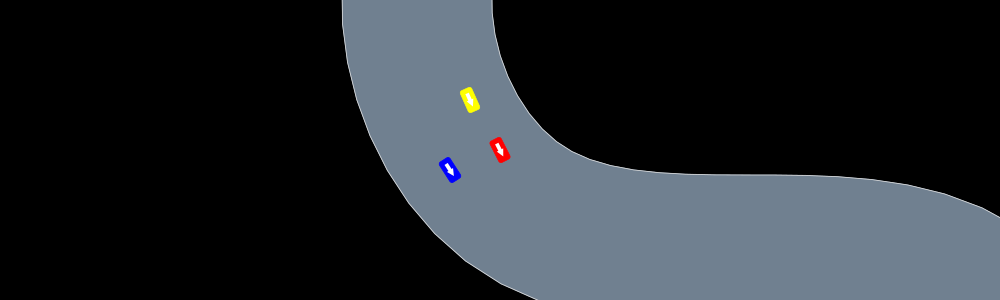

In [4]:
DemoState(track,scene,carcolors)

### Discrete Action Space
After observing the current state, the agent executes an action:

$$a = (\Delta v, \delta)$$

where $\Delta v$ and $\delta$ are chosen from a finite set of options:
$$\Delta v \in \left[ -\Delta v_{max}, \cdots, 0, \cdots, \Delta v_{max} \right], $$ $$ \delta \in \left[-\delta_{max}, \cdots, 0, \cdots, \delta_{max} \right]$$

Thus, the number of actions to choose from at a given time step is $|\mathcal{A}| = |\mathcal{V}| \times |\mathcal{\delta}|$. In this particular implementation, there are only three options for acceleration: $\Delta v \in \left[ -\Delta v_{max}, 0, \Delta v_{max} \right]$ 

### State Transition Update
The state of the vehicle evolves  deterministically as a function of the selected action. The position update equations are based on the bicycle kinematic model with a no-slip constraint. These equations can be found in the function $HierarchicalRecedingHorizonController.generateMotionMap()$. Bear in mind that the update equations are calculated assuming an initial yaw angle of zero. Obviously a coordinate transformation is necessary to compute the actual state update. 

The update rules for velocity and steering angle are given here:

\begin{align*}
& v_{t_{n}} = v_{t_{n-1}} + \Delta v & 0 \leq v \leq v_{max} & \\
& \delta_{t_{n}} = \delta & |\delta| < \delta_{max}(v)
\end{align*}

$\delta_{max}$ is a function of the vehicle's current velocity, and represents the steering angle above which tire saturation (slipping) would occur.
If the constraints are violated, $v$ and/or $\delta$ are thresholded accordingly. 

### Motion Primitives for Trajectory Planning

The motion primitives represent feasible trajectories over the planning horizon $h$. These candidate trajectories are computed offline and stored in a dictionary, $HRHC.motion\_map$, which is accessed by the index of the agent's current velocity. Thus, at velocity 50, the agent uses the candidate trajectories calculated for that velocity in its planning. 

The number of candidate trajectories calculated for each starting velocity is equal to the number of possible actions $\mathcal{A}$ Each candidate trajectory is computed offline in the following manner: 

Begin at an initial velocity $v_{t_0}$

For $\Delta v \in \left[-\Delta v_{max}, 0, \Delta v_{max} \right]$:

&nbsp;&nbsp;&nbsp;&nbsp; 
For $\delta \in \left[-\delta_{max}, \cdots, 0, \cdots, \delta_{max} \right]$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
For $i \in \left[0, 1, \cdots, h-1, h \right]$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$ v_{t_{i}} = v_{t_{i-1}} + \Delta v $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$ \delta_{t_{i}} = \delta $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update $x,y,\theta$ according to update rules in $HierarchicalRecedingHorizonController.generateMotionMap()$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
End

&nbsp;&nbsp;&nbsp;&nbsp;
End

End

If $|\delta| > \delta_{max}(v)$, $\delta$ is thresholded to $\delta_{max}$ and  $\Delta v$ is set to $ -\Delta v_{max}$. Thus, the velocity continuously decreases for that candidate trajectory until the desired steering angle is reachable. This behavior is demonstrated in the second demo below, with a high starting velocity and a long planning horizon.


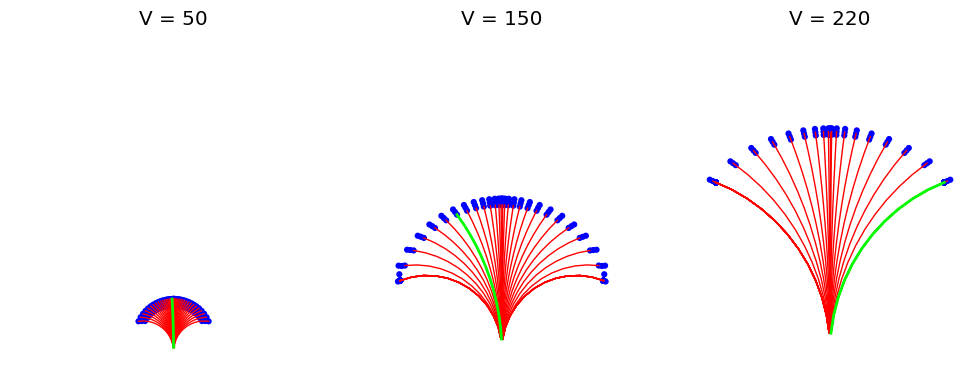

In [5]:
# Visualize candidate trajectories for several different velocities
DemoMotionPrimitives(track,context)

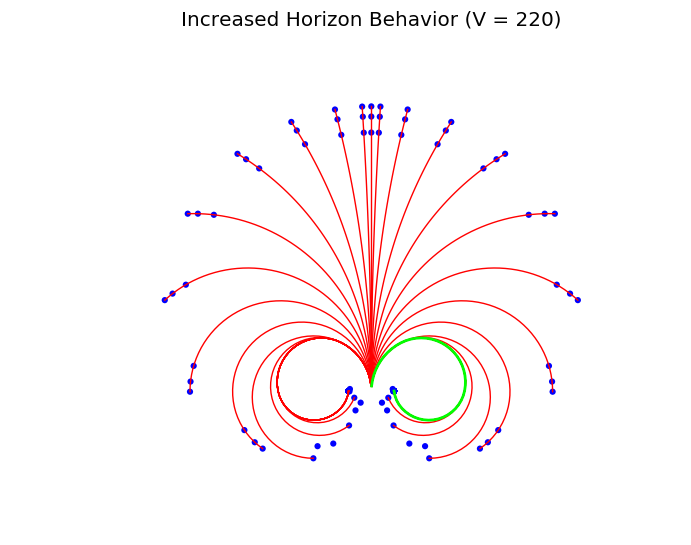

PyObject <matplotlib.text.Text object at 0x322afa690>

In [6]:
# Visualize candidate trajectories for an increased planning horizon
DemoIncreasedHorizonBehavior(track,context)

### Reward Shaping: Building the Objective Function
With candidate trajectories for every reachable velocity, the agent can plan ahead $h$ time steps and select the action expected to maximize future reward. The idea is to reward progress along the track (measured by $\Delta s$) while penalizing the states where the vehicle would be too close to the track boundaries. One key aspect of the objective function is that it imposes a penalty for yaw angle in the same direction as the lateral displacement from the centerline. For example, there is a very high penalty for being on the left side of the track AND angling left. Intuitively, this is a bad situation because it means the vehicle is about to drive off the left side of the track. There is a much lower penalty for being on the left side of the track and angling right (because the vehicle is driving back to the center).  In this approach, the reward function to be maximized is replaced with a cost function to be minimized. Here are the building blocks of the objective function:

##### Incentivize progress along the track

$$ Obj(s) = \Big(\frac{s}{s-s_0}\Big),$$
where $s_0$ is the vehicle's current $s$ value.

#### Penalize being too close to the edge of the track

$$ Obj(t) = \Big(\frac{t}{T_{max}}\Big)^6$$
Note that the maximum penalty is $1.0$. The idea here is that the penalty only becomes large when the vehicle is VERY close to the edge of the track.

#### Penalize high yaw angle

$$ Obj(t) = \Big(\frac{\phi}{\phi_{max}}\Big)^6,$$
Where $\phi_{max} = \pi$. The idea is to penalize driving in a direction no aligned with the track centerline.

#### Penalize being too close to the edge of the track AND driving off the track

$$ Obj(t,\phi) = p^T A p,$$
where 
$$
p = 
\begin{bmatrix}
\frac{t}{T_{max}}\\
\frac{\phi}{\phi_{max}} \\
\end{bmatrix}
$$
and 
$$
A = 
\begin{bmatrix}
1 & .5 \\
.5 & 0 \\
\end{bmatrix} 
$$

#### Full objective function
The complete objective function is simply a linear combination of the above objectives:

$$ Obj(s,t,\phi) = c_s Obj(s) + c_t Obj(t) + c_\phi Obj(\phi) + c_{t,\phi} Obj(t,\phi)$$

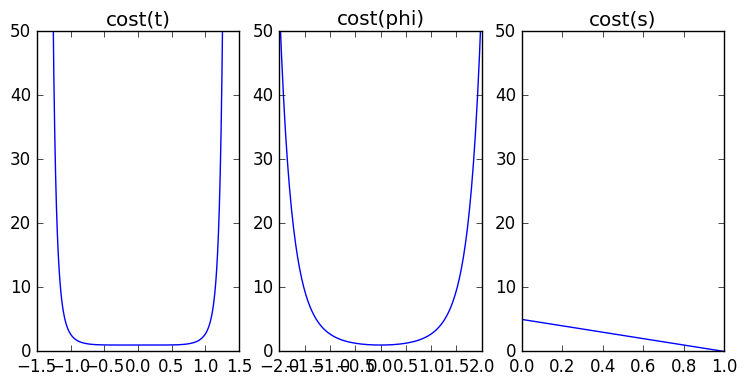

PyObject <matplotlib.text.Text object at 0x325605a10>

In [7]:
DemoBuildingBlocks()

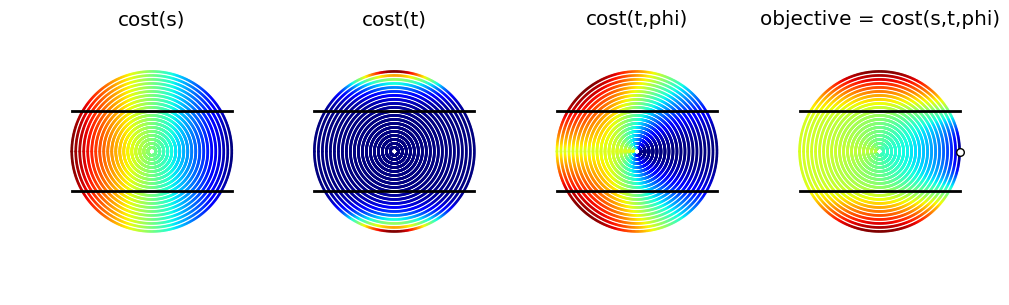

PyObject <matplotlib.text.Text object at 0x322a8a190>

In [8]:
# Heat map of the objective function 
# Modify t_shift to see how the objective function changeswhen the car is closer to the edge of the road
t_shift = 0
DemoObjective(t_shift)

# Cost of Collision

The one thing missing from the objective function is a penalty, $Obj_{collision}$, for collision with other vehicles. This value is calculated as follows:


#### Draw Bounding Ellipse

Draw an ellipse around each vehicle. The semi-major axes of the ellipse are computed by finding the ellipse of minimum area that completely encloses the vehicle. I won't go through the full derivation here, but semi-major axes $A$ and $B$ are defined as follows:

\begin{align*}
& B = \sqrt{\frac{-b + \sqrt{b^2 - 4*a*c}}{2*a}} & \\
& A = \sqrt{\frac{W^2}{1 - \big(\frac{L}{B}\big)^2}}
\end{align*}

where $ a = 2$, $ b = -4 L - 2 W^2 L^2 $, $ c = 2 L^4 $, where $L$ is the length of the vehicle and $W$ is the width of the vehicle. The equation for B is recognizable as the quadratic equation, but in this case we are solving for $B^2$ (hence we take the square root of the whole quantity to obtain $B$).

#### Check for overlap of bounding ellipses

This is not a fool proof overlap checker, but it does a good job of determining when collisions are expected. It works as follows:

Calculate the distance between the two vehicles (center to center):

$$ R = \sqrt{\Delta x^2 + \Delta y^2} $$

Calculate the angular offset between the vehicles

$$ \zeta = atan2(\Delta y, \Delta x) $$

Calculate the difference between the angular offset and the heading offset:

$$ \psi = \zeta - \theta_2 - \theta_1 $$

Calculate the elliptical radii along the line between the two vehicles' centers:

$$ r_1 = \frac{W L}{\sqrt{L^2 sin(\zeta)^2 + W^2 cos(\zeta)^2}} $$
$$ r_2 = \frac{W L}{\sqrt{L^2 sin(\psi)^2 + W^2 cos(\psi)^2}} $$

If $ r_1 + r_2 \geq R \Rightarrow Overlap \Rightarrow Collision $

#### Penalty for Collision
When a collision is predicted, the objective function is set to $\inf$

# Other Objective Function Visualizations

#### Fixing the Tailgating Problem

It turns out that cars get "stuck" behind each other. To fix this, I have added a penalty to the objective function that discourages tailgating.

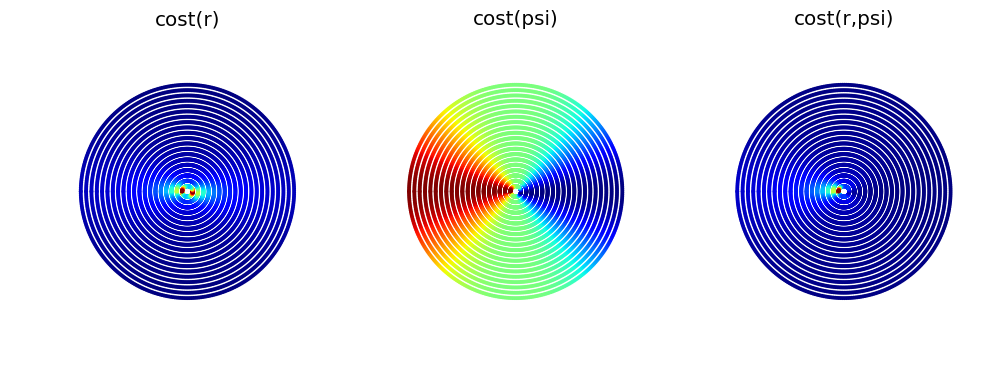

In [9]:
x,y,Rψ_cost = DemoTailgateAvoidance()
Rψ_cost;

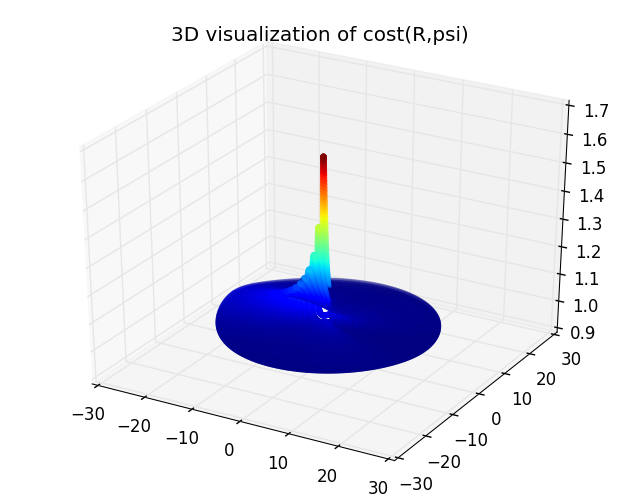

PyObject <matplotlib.text.Text object at 0x32244ee50>

In [10]:
PyPlot.scatter3D(x,y,Rψ_cost,c=Rψ_cost,edgecolor="none")
# PyPlot.axis("off")
PyPlot.title("3D visualization of cost(R,psi)")

## Objective Function in Action

The agents determine which action to take by calculating the cost of each candidate trajectory, throwing out all trajectories expected to yield a collision, then selecting the optimal trajectory with respect to the objective function. It then executes the associated action for one time step and repeats the planning process.  You can watch the vehicle(s) planning and executing by running the following cell repeatedly.

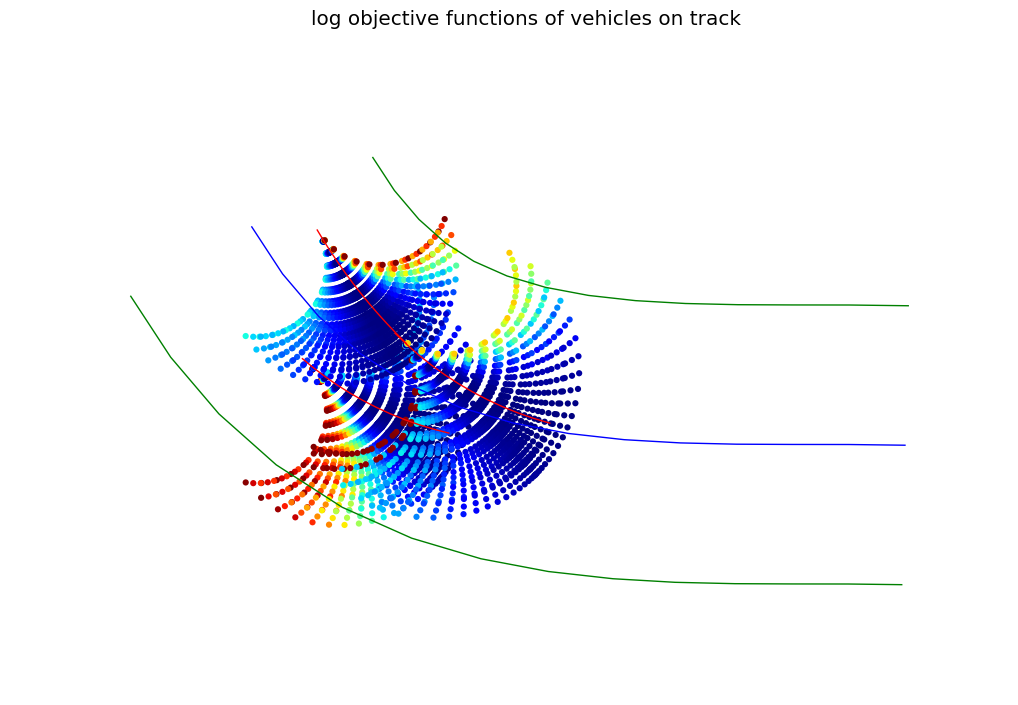

(-180.0,-80.0,-120.0,-60.0)

In [11]:
DemoObserveActObjective(track,scene,steps=6)

## Level-K Reasoning

Each agent on the track has an associated logit level equal to or greater than 1. Level 1 cars assume all other cars reason at level 0 (unaware of other vehicles), level 2 cars assume all other cars reason at level 1, etc. The enabling data structure for this reasoning is a nested Dictionary called $track.obstacleMap$. It stores the selected optimal trajectories for every car at every level. There is no uncertainty (yet!) in the state, so these are the actual trajectories that will be followed by the vehicles of the corrseponding logit level for the next time step.
The trajectories can be visualized below.

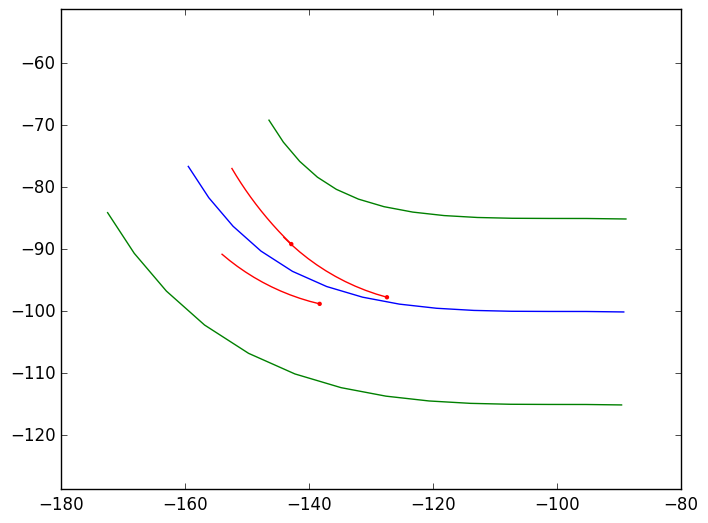

(-180.0,-80.0,-120.0,-60.0)

In [12]:
k_level = 1
DemoObstacleMap(track,k_level)

## Future Work

There are a whole lot of cool things that can be done with this. The value function could be learned rather than hand-crafted. Obviously we'll want to introduce uncertainty and partial visibility into the problem. I'll be moving on to other projects, but let me know if you'd like to get involved in taking this project forward!